# Week 4: Advanced ML - Ensembles


In [1]:
import pandas as pd
import numpy as np

# ============================================================================
# WEEK 4: ADVANCED ML - ENSEMBLE METHODS
# ============================================================================
# This notebook combines concepts from previous weeks:
# - Week 1: Classification (expense categorization)
# - Week 2: Time-series features (lagging features for forecasting)
# - Week 3: Clustering (user segments)
# - Week 4: Ensemble methods (combining multiple models)
#
# ENSEMBLE LEARNING: Using multiple models together to make better predictions
# - Idea: "Wisdom of the crowd" - multiple opinions are better than one
# - Types: Bagging, Boosting, Stacking
# - Benefits: Better accuracy, more robust, handles overfitting
# ============================================================================

print("="*70)
print("LOADING DATA AND FEATURE ENGINEERING")
print("="*70)

# Load data from previous weeks
df = pd.read_csv('../data/synthetic_expenses.csv')

print(f"Loaded {len(df)} expense records")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

# ============================================================================
# CONCEPT 1: FEATURE ENGINEERING - Creating New Features
# ============================================================================
# Feature Engineering: Creating new features from existing data to improve
# model performance. Good features = better predictions!
#
# Types of Feature Engineering:
# 1. Derived Features: Combine existing features (e.g., family_size)
# 2. Lag Features: Use past values (from Week 2 - time-series)
# 3. Cluster Features: Use cluster assignments (from Week 3 - segmentation)
# 4. Aggregated Features: Summarize groups (e.g., average spending)
# ============================================================================

# Example: Derived feature (if we had family data)
# This is just an example - your data might not have these columns
if 'sibsp' in df.columns and 'parch' in df.columns:
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    print("\n✅ Created derived feature: family_size")
else:
    print("\n⚠️  No family data columns found (sibsp, parch)")

# ============================================================================
# CONCEPT 2: LAG FEATURES (From Week 2 - Time Series)
# ============================================================================
# Lag Features: Using PAST values to predict FUTURE values
#
# What is "Lag"?
# - Lag-1: Value from 1 time period ago (previous month)
# - Lag-2: Value from 2 time periods ago (2 months ago)
# - Lag-n: Value from n time periods ago
#
# Why Use Lag Features?
# - Time-series data has temporal dependencies
# - Past spending predicts future spending
# - Example: If you spent $1000 last month, you might spend similarly this month
#
# How It Works:
#   Original:  [100, 150, 200, 180, 220]
#   Lag-1:     [NaN, 100, 150, 200, 180]  ← Shifted by 1
#   Lag-2:     [NaN, NaN, 100, 150, 200]  ← Shifted by 2
#
# Real Example:
#   Month 1: Spend $1000 → Lag-1 for Month 2 = $1000
#   Month 2: Spend $1200 → Lag-1 for Month 3 = $1200
#   Month 3: Spend $1100 → Lag-1 for Month 4 = $1100
# ============================================================================

print("\n" + "="*70)
print("ADDING LAG FEATURES (Time-Series Features from Week 2)")
print("="*70)

# Check if we have date column for time-series features
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    # Create lag features for amount (spending patterns)
    # Lag-1: Previous period's spending
    df['amount_lag1'] = df['amount'].shift(1)
    
    # Lag-2: Two periods ago spending
    df['amount_lag2'] = df['amount'].shift(2)
    
    # Rolling average (moving average) - another time-series feature
    df['amount_rolling_mean_3'] = df['amount'].rolling(window=3, min_periods=1).mean()
    
    print("✅ Created lag features:")
    print("   - amount_lag1: Previous period's spending")
    print("   - amount_lag2: Two periods ago spending")
    print("   - amount_rolling_mean_3: 3-period moving average")
    print("\nExample of lag features:")
    print(df[['date', 'amount', 'amount_lag1', 'amount_lag2', 'amount_rolling_mean_3']].head(10))
else:
    print("⚠️  No 'date' column found - skipping lag features")
    print("   (Lag features require time-series data)")

# ============================================================================
# CONCEPT 3: CLUSTER FEATURES (From Week 3 - User Segmentation)
# ============================================================================
# Cluster Features: Using cluster assignments as features
#
# What is a Cluster?
# - A group of similar data points
# - In Week 3, we grouped users by spending behavior
# - Example clusters: "Big Spenders", "Budget Conscious", "Entertainment Lovers"
#
# Why Use Cluster Features?
# - Captures complex patterns in one categorical feature
# - Users in same cluster have similar behavior
# - Helps model understand user segments
#
# How It Works:
#   User A: Spending pattern → Cluster 0 ("Big Spender")
#   User B: Spending pattern → Cluster 0 ("Big Spender")
#   User C: Spending pattern → Cluster 1 ("Budget Conscious")
#
#   Cluster becomes a feature: cluster = 0 or 1 or 2...
#
# Real Example:
#   - Cluster 0 users: High spending across all categories
#   - Cluster 1 users: Low spending, focus on essentials
#   - Cluster 2 users: High entertainment, low utilities
#
# The model learns: "Users in Cluster 0 tend to spend more"
# ============================================================================

print("\n" + "="*70)
print("ADDING CLUSTER FEATURES (User Segments from Week 3)")
print("="*70)

# In a real scenario, you would load cluster assignments from Week 3
# For now, we'll create a simple example cluster feature
# (In practice, this would come from your Week 3 clustering results)

# Example: Create cluster based on spending amount (simplified)
if 'amount' in df.columns:
    # Simple clustering: High/Medium/Low spenders
    df['spending_cluster'] = pd.cut(
        df['amount'],
        bins=[0, 100, 300, float('inf')],
        labels=['Low', 'Medium', 'High']
    )
    
    # Convert to numeric for model (if needed)
    cluster_map = {'Low': 0, 'Medium': 1, 'High': 2}
    df['cluster_id'] = df['spending_cluster'].map(cluster_map)
    
    print("✅ Created cluster feature:")
    print("   - spending_cluster: User spending segment (Low/Medium/High)")
    print("   - cluster_id: Numeric cluster ID (0/1/2)")
    print("\nCluster distribution:")
    print(df['spending_cluster'].value_counts())
else:
    print("⚠️  No 'amount' column found - skipping cluster features")

# ============================================================================
# CONCEPT 4: PREPARING DATA FOR ENSEMBLE MODELS
# ============================================================================
# Now we prepare features (X) and target (y) for machine learning
#
# Features (X): What the model uses to make predictions
#   - Original features: amount, description, date
#   - Engineered features: lag features, cluster features
#   - All features together help the model learn patterns
#
# Target (y): What we want to predict
#   - Classification: category (which expense category?)
#   - Regression: amount (how much will be spent?)
# ============================================================================

print("\n" + "="*70)
print("PREPARING FEATURES AND TARGET")
print("="*70)

# Prepare features (X) - everything except the target
# Drop target column and any non-feature columns
columns_to_drop = []
if 'category' in df.columns:
    columns_to_drop.append('category')
if 'spending_cluster' in df.columns:
    columns_to_drop.append('spending_cluster')  # Keep cluster_id, drop label

X = df.drop(columns_to_drop, axis=1, errors='ignore')

# Prepare target (y) - what we want to predict
if 'category' in df.columns:
    y = df['category']  # Classification task
    print("✅ Target: 'category' (Classification - predicting expense category)")
elif 'amount' in df.columns:
    y = df['amount']  # Regression task
    print("✅ Target: 'amount' (Regression - predicting spending amount)")
else:
    y = None
    print("⚠️  No target column found")

# Handle missing values from lag features
X = X.fillna(0)  # Replace NaN with 0 (or use forward fill, mean, etc.)

print(f"\n✅ Features (X) shape: {X.shape}")
print(f"   - {X.shape[0]} samples (rows)")
print(f"   - {X.shape[1]} features (columns)")
print(f"\n✅ Target (y) shape: {y.shape if y is not None else 'None'}")
print(f"\nFeature columns: {list(X.columns)}")

print("\n" + "="*70)
print("SUMMARY: KEY CONCEPTS EXPLAINED")
print("="*70)
print("1. FEATURE ENGINEERING: Creating new features from existing data")
print("2. LAG FEATURES: Using past values to predict future (time-series)")
print("3. CLUSTER FEATURES: Using user segments as features")
print("4. FEATURE PREPARATION: Organizing data for machine learning")
print("="*70)

print("\n📊 Final dataset preview:")
print(df.head())

LOADING DATA AND FEATURE ENGINEERING
Loaded 10000 expense records
Columns: ['date', 'description', 'amount', 'category']

First few rows:
         date                                description      amount  \
0  2024-09-04           Life order relate idea a follow.  286.896893   
1  2025-01-24        Themselves middle break yet notice.  192.898054   
2  2024-01-31  Account region available natural perhaps.  224.936664   
3  2025-12-07                    Office conference drop.  117.974528   
4  2025-03-09         Yet money many moment choice door.   88.962677   

        category  
0     Dining Out  
1     Healthcare  
2      Utilities  
3  Entertainment  
4     Healthcare  

⚠️  No family data columns found (sibsp, parch)

ADDING LAG FEATURES (Time-Series Features from Week 2)
✅ Created lag features:
   - amount_lag1: Previous period's spending
   - amount_lag2: Two periods ago spending
   - amount_rolling_mean_3: 3-period moving average

Example of lag features:
        date      am

In [2]:
# ============================================================================
# ENSEMBLE LEARNING - COMPREHENSIVE GUIDE
# ============================================================================
# This cell provides a complete explanation of ensemble learning methods
# ============================================================================

print("="*70)
print("ENSEMBLE LEARNING - COMPLETE GUIDE")
print("="*70)

# ============================================================================
# WHAT IS ENSEMBLE LEARNING?
# ============================================================================
# Ensemble Learning: Combining multiple machine learning models to create
# a more powerful and accurate prediction system.
#
# Core Philosophy: "Wisdom of the Crowd"
# - Multiple opinions are better than one
# - Different models catch different patterns
# - Errors cancel out when models disagree
# - Similar to asking multiple experts and taking their consensus
#
# Analogy:
#   Single Model: Asking one doctor for diagnosis
#   Ensemble: Asking 10 doctors and taking majority vote
#   Result: More reliable and accurate diagnosis
# ============================================================================

print("\n" + "="*70)
print("1. WHAT IS ENSEMBLE LEARNING?")
print("="*70)
print("""
Ensemble Learning = Combining multiple models for better predictions

Key Idea: "Wisdom of the Crowd"
- Multiple models → Multiple perspectives
- Errors cancel out → More robust predictions
- Different models catch different patterns → Better coverage

Real-World Analogy:
  Single Model: One weather forecaster
  Ensemble: 100 weather forecasters voting
  Result: More accurate weather prediction
""")

# ============================================================================
# WHY USE ENSEMBLE LEARNING?
# ============================================================================
# Benefits:
# 1. Better Accuracy: Often 5-20% improvement over single models
# 2. More Robust: Less sensitive to outliers and noise
# 3. Reduces Overfitting: Multiple models prevent memorization
# 4. Handles Complexity: Captures patterns single models miss
# 5. Error Reduction: Mistakes from one model offset by others
#
# Trade-offs:
# - More computational cost (train multiple models)
# - More complex to understand and explain
# - Takes longer to train and predict
# ============================================================================

print("\n" + "="*70)
print("2. WHY USE ENSEMBLE LEARNING?")
print("="*70)
print("""
Benefits:
✅ Better Accuracy: 5-20% improvement over single models
✅ More Robust: Less sensitive to outliers and noise
✅ Reduces Overfitting: Multiple models prevent memorization
✅ Handles Complexity: Captures patterns single models miss
✅ Error Reduction: Mistakes cancel out

Trade-offs:
⚠️  More computational cost (train multiple models)
⚠️  More complex to understand and explain
⚠️  Takes longer to train and predict
""")

# ============================================================================
# TYPE 1: BAGGING (Bootstrap Aggregating)
# ============================================================================
# Bagging: Train multiple models on different random subsets of data,
#          then average/vote their predictions
#
# How It Works:
# 1. Create multiple bootstrap samples (random sampling with replacement)
# 2. Train a model on each sample (same algorithm, different data)
# 3. For prediction: Average (regression) or Vote (classification)
#
# Key Characteristics:
# - Models trained in PARALLEL (independent)
# - Reduces VARIANCE (model sensitivity to data)
# - Works well with high-variance models (Decision Trees, Neural Networks)
# - Each model sees ~63% of data (bootstrap sampling)
#
# Examples:
# - Random Forest: Bagging of Decision Trees
# - Extra Trees: More randomized version of Random Forest
#
# When to Use:
# - High variance models (overfitting)
# - Large datasets
# - Want parallel training
# ============================================================================

print("\n" + "="*70)
print("3. TYPE 1: BAGGING (Bootstrap Aggregating)")
print("="*70)
print("""
Definition: Train multiple models on different random data subsets,
            then combine their predictions

How It Works:
  1. Create bootstrap samples (random sampling WITH replacement)
  2. Train model on each sample (same algorithm, different data)
  3. Predict: Average (regression) or Majority Vote (classification)

Key Characteristics:
  ✅ Models trained in PARALLEL (independent, can train simultaneously)
  ✅ Reduces VARIANCE (less sensitive to data changes)
  ✅ Works well with high-variance models (Decision Trees, Neural Nets)
  ✅ Each model sees ~63% of data (bootstrap sampling)

Bootstrap Sampling:
  - Random sampling WITH replacement
  - Sample size = original dataset size
  - Some samples appear multiple times, some not at all
  - Each sample is different → different models

Example: Random Forest
  - 100 Decision Trees, each on different bootstrap sample
  - Final prediction = majority vote of all trees
  - More trees = better (but diminishing returns)

When to Use:
  ✅ High variance models (overfitting)
  ✅ Large datasets
  ✅ Want parallel training (faster)
  ✅ Need robust predictions
""")

# ============================================================================
# TYPE 2: BOOSTING
# ============================================================================
# Boosting: Train models SEQUENTIALLY, where each model learns from
#           the mistakes of previous models
#
# How It Works:
# 1. Train first model on all data
# 2. Identify mistakes (misclassified/poorly predicted examples)
# 3. Train next model focusing on mistakes (give them more weight)
# 4. Repeat: Each model corrects previous errors
# 5. Combine all models with weights (better models get more weight)
#
# Key Characteristics:
# - Models trained SEQUENTIALLY (one after another)
# - Reduces BIAS (systematic errors)
# - Each model focuses on previous mistakes
# - Adaptive: Learns from errors
#
# Types of Boosting:
# 1. AdaBoost (Adaptive Boosting): Original boosting algorithm
# 2. Gradient Boosting: Uses gradient descent to minimize errors
# 3. XGBoost: Optimized gradient boosting (very popular)
# 4. LightGBM: Fast gradient boosting (Microsoft)
# 5. CatBoost: Handles categorical features well
#
# When to Use:
# - High bias models (underfitting)
# - Want maximum accuracy
# - Can wait for sequential training
# - Small to medium datasets
# ============================================================================

print("\n" + "="*70)
print("4. TYPE 2: BOOSTING")
print("="*70)
print("""
Definition: Train models SEQUENTIALLY, each learning from previous mistakes

How It Works:
  1. Train Model 1 on all data
  2. Identify mistakes (misclassified examples)
  3. Train Model 2 focusing on mistakes (give them more weight)
  4. Train Model 3 focusing on Model 2's mistakes
  5. Continue: Each model corrects previous errors
  6. Combine with weights (better models get more influence)

Key Characteristics:
  ✅ Models trained SEQUENTIALLY (one after another, dependent)
  ✅ Reduces BIAS (systematic errors, underfitting)
  ✅ Adaptive learning: Each model learns from previous mistakes
  ✅ Focused: Later models specialize on hard examples

Boosting Types:
  1. AdaBoost: Original, gives more weight to mistakes
  2. Gradient Boosting: Uses gradient descent to minimize errors
  3. XGBoost: Optimized, very popular, handles missing values
  4. LightGBM: Fast, good for large datasets
  5. CatBoost: Excellent with categorical features

Example: AdaBoost
  - Model 1: Classifies 80% correctly, 20% wrong
  - Model 2: Focuses on the 20% mistakes
  - Model 3: Focuses on remaining mistakes
  - Final: Weighted combination of all models

When to Use:
  ✅ High bias models (underfitting)
  ✅ Want maximum accuracy
  ✅ Can wait for sequential training
  ✅ Small to medium datasets
  ✅ Need to handle complex patterns
""")

# ============================================================================
# TYPE 3: STACKING (Stacked Generalization)
# ============================================================================
# Stacking: Train a "meta-learner" (second-level model) that learns
#           how to best combine predictions from multiple "base learners"
#
# How It Works:
# 1. Train multiple base models (different algorithms)
# 2. Get predictions from each base model
# 3. Use these predictions as FEATURES for meta-learner
# 4. Train meta-learner to learn optimal combination
# 5. Final prediction = meta-learner's prediction
#
# Key Characteristics:
# - Two levels: Base models + Meta-learner
# - Meta-learner learns HOW to combine base models
# - Can use different algorithms for base and meta
# - More flexible than simple voting/averaging
#
# Example:
#   Base Models: Logistic Regression, Random Forest, SVM
#   Meta-Learner: Linear Regression (learns weights)
#   Final: Meta-learner combines base predictions optimally
#
# When to Use:
# - Have diverse base models
# - Want optimal combination
# - Have enough data for meta-learner
# - Need best possible accuracy
# ============================================================================

print("\n" + "="*70)
print("5. TYPE 3: STACKING (Stacked Generalization)")
print("="*70)
print("""
Definition: Train a "meta-learner" that learns how to best combine
            predictions from multiple base models

How It Works:
  1. Train multiple BASE models (different algorithms)
     - Example: Logistic Regression, Random Forest, SVM
  2. Get predictions from each base model
  3. Use predictions as FEATURES for META-LEARNER
  4. Train meta-learner to learn optimal combination
  5. Final prediction = meta-learner's output

Key Characteristics:
  ✅ Two levels: Base models (Level 1) + Meta-learner (Level 2)
  ✅ Meta-learner learns HOW to combine base models
  ✅ Can use different algorithms for base and meta
  ✅ More flexible than simple voting/averaging

Example Structure:
  Level 1 (Base Models):
    - Model A: Logistic Regression → Prediction A
    - Model B: Random Forest → Prediction B
    - Model C: SVM → Prediction C
  
  Level 2 (Meta-Learner):
    - Input: [Prediction A, Prediction B, Prediction C]
    - Algorithm: Linear Regression or Neural Network
    - Output: Final optimized prediction

Why It Works:
  - Different models have different strengths
  - Meta-learner learns which model to trust for which cases
  - More sophisticated than simple averaging

When to Use:
  ✅ Have diverse base models (different algorithms)
  ✅ Want optimal combination (not just average)
  ✅ Have enough data for meta-learner training
  ✅ Need best possible accuracy
  ✅ Willing to invest in complexity
""")

# ============================================================================
# TYPE 4: VOTING (Hard & Soft Voting)
# ============================================================================
# Voting: Simple ensemble where multiple models vote on the prediction
#
# Hard Voting:
# - Each model predicts a class
# - Final prediction = majority vote (most common class)
# - Example: 3 models predict [A, A, B] → Final = A
#
# Soft Voting:
# - Each model outputs probabilities
# - Final prediction = average probabilities, then pick highest
# - Example: Model 1: [0.7, 0.3], Model 2: [0.6, 0.4] → Average: [0.65, 0.35] → Class 1
#
# Key Characteristics:
# - Simplest ensemble method
# - No training of combination (just vote/average)
# - Works well with diverse models
# - Fast and interpretable
#
# When to Use:
# - Want simple ensemble
# - Have diverse models
# - Need fast predictions
# - Classification tasks
# ============================================================================

print("\n" + "="*70)
print("6. TYPE 4: VOTING (Hard & Soft Voting)")
print("="*70)
print("""
Definition: Multiple models vote on the final prediction

Hard Voting:
  - Each model predicts a CLASS (category)
  - Final prediction = MAJORITY VOTE (most common class)
  - Example: 5 models predict [A, A, A, B, B] → Final = A (3 votes)

Soft Voting:
  - Each model outputs PROBABILITIES
  - Final prediction = AVERAGE probabilities, pick highest
  - Example:
      Model 1: [0.7, 0.2, 0.1] for classes [A, B, C]
      Model 2: [0.6, 0.3, 0.1]
      Model 3: [0.5, 0.4, 0.1]
      Average: [0.6, 0.3, 0.1] → Final = A (highest probability)

Key Characteristics:
  ✅ Simplest ensemble method
  ✅ No training of combination (just vote/average)
  ✅ Works well with diverse models
  ✅ Fast and interpretable
  ✅ Soft voting usually better (uses probability information)

Requirements:
  - Hard Voting: Models must predict classes
  - Soft Voting: Models must output probabilities

When to Use:
  ✅ Want simple ensemble (easiest to implement)
  ✅ Have diverse models (different algorithms)
  ✅ Need fast predictions
  ✅ Classification tasks
  ✅ Soft voting preferred when models output probabilities
""")

# ============================================================================
# TYPE 5: BLENDING
# ============================================================================
# Blending: Similar to stacking, but simpler - manually combine
#           predictions with fixed weights or simple rules
#
# How It Works:
# 1. Train multiple models
# 2. Get predictions from each
# 3. Combine with fixed weights or simple formula
# 4. No meta-learner training
#
# Key Characteristics:
# - Simpler than stacking (no meta-learner)
# - Weights can be learned or set manually
# - Faster than stacking
# - Less flexible than stacking
#
# When to Use:
# - Want something between voting and stacking
# - Have domain knowledge about model weights
# - Need faster training than stacking
# ============================================================================

print("\n" + "="*70)
print("7. TYPE 5: BLENDING")
print("="*70)
print("""
Definition: Manually combine predictions with fixed weights or simple rules
            (Simpler version of stacking)

How It Works:
  1. Train multiple models
  2. Get predictions from each model
  3. Combine with fixed weights or simple formula
  4. No meta-learner training (unlike stacking)

Key Characteristics:
  ✅ Simpler than stacking (no meta-learner to train)
  ✅ Weights can be learned or set manually
  ✅ Faster than stacking
  ⚠️  Less flexible than stacking

Example:
  Model 1 (Random Forest): Prediction = 0.7
  Model 2 (SVM): Prediction = 0.8
  Model 3 (Logistic Regression): Prediction = 0.6
  
  Blending with weights [0.4, 0.4, 0.2]:
    Final = 0.4*0.7 + 0.4*0.8 + 0.2*0.6 = 0.72

When to Use:
  ✅ Want something between voting and stacking
  ✅ Have domain knowledge about model weights
  ✅ Need faster training than stacking
  ✅ Want more control than voting
""")

# ============================================================================
# COMPARISON TABLE
# ============================================================================

print("\n" + "="*70)
print("8. COMPARISON: WHEN TO USE WHICH METHOD?")
print("="*70)
print("""
┌─────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│   Method    │   Training   │   Reduces    │   Best For   │   Examples   │
├─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│  BAGGING    │  Parallel    │  Variance    │  Overfitting │ Random Forest│
│             │  (fast)      │  (noise)     │  High var    │ Extra Trees  │
├─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│  BOOSTING   │  Sequential  │  Bias        │  Underfitting│ XGBoost      │
│             │  (slow)      │  (errors)    │  High bias   │ LightGBM     │
├─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│  STACKING   │  Two-level   │  Both        │  Max accuracy│ Custom stack │
│             │  (complex)   │              │  Diverse mods│              │
├─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│  VOTING     │  Independent │  Errors      │  Simple      │ Voting       │
│             │  (simple)    │              │  Fast        │ Classifier   │
├─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│  BLENDING   │  Independent │  Errors      │  Medium      │ Weighted avg │
│             │  (medium)    │              │  complexity  │              │
└─────────────┴──────────────┴──────────────┴──────────────┴──────────────┘

Key Differences:
  Training Speed: Bagging = Voting = Blending > Stacking > Boosting
  Complexity: Voting < Blending < Bagging < Boosting < Stacking
  Accuracy Potential: Voting < Blending < Bagging < Boosting < Stacking
  Interpretability: Voting > Blending > Bagging > Boosting > Stacking
""")

# ============================================================================
# KEY CONCEPTS IN ENSEMBLE LEARNING
# ============================================================================

print("\n" + "="*70)
print("9. KEY CONCEPTS IN ENSEMBLE LEARNING")
print("="*70)
print("""
1. DIVERSITY (Critical for Good Ensembles)
   - Models should make DIFFERENT mistakes
   - If all models agree, ensemble = single model
   - Diversity sources:
     * Different algorithms (Logistic Regression vs Random Forest)
     * Different features (subset of features)
     * Different data (bootstrap samples)
     * Different hyperparameters

2. BIAS vs VARIANCE
   - Bias: Systematic error (underfitting)
   - Variance: Sensitivity to data changes (overfitting)
   - Bagging reduces VARIANCE
   - Boosting reduces BIAS
   - Stacking can reduce BOTH

3. OVERFITTING IN ENSEMBLES
   - Ensembles can still overfit!
   - Too many models = memorization
   - Need validation to tune ensemble size
   - Cross-validation important

4. MODEL CORRELATION
   - Low correlation between models = Better ensemble
   - High correlation = Less benefit
   - Diversity reduces correlation

5. COMBINATION STRATEGIES
   - Average: Simple, works well
   - Weighted Average: Better models get more weight
   - Voting: For classification
   - Stacking: Learned combination (most flexible)
""")

# ============================================================================
# PRACTICAL TIPS
# ============================================================================

print("\n" + "="*70)
print("10. PRACTICAL TIPS FOR ENSEMBLE LEARNING")
print("="*70)
print("""
✅ Start Simple:
   - Try Voting Classifier first (easiest)
   - Then try Bagging (Random Forest)
   - Then Boosting (XGBoost)
   - Finally Stacking (if needed)

✅ Ensure Diversity:
   - Use different algorithms
   - Use different features
   - Use different hyperparameters
   - Don't use identical models

✅ Validate Properly:
   - Use cross-validation
   - Separate validation set for meta-learner (stacking)
   - Watch for overfitting

✅ Consider Trade-offs:
   - Accuracy vs Speed
   - Complexity vs Interpretability
   - Training time vs Prediction time

✅ Common Mistakes:
   ❌ Using identical models (no diversity)
   ❌ Too many models (overfitting)
   ❌ Not validating properly
   ❌ Ignoring computational cost
   ❌ Using ensemble when single model is sufficient
""")

print("\n" + "="*70)
print("ENSEMBLE LEARNING GUIDE COMPLETE!")
print("="*70)
print("""
Next Steps:
1. Try implementing different ensemble methods
2. Compare their performance
3. Understand when each works best
4. Practice with real datasets

Remember: Ensemble learning is a powerful tool, but not always necessary.
          Sometimes a well-tuned single model is sufficient!
""")


ENSEMBLE LEARNING - COMPLETE GUIDE

1. WHAT IS ENSEMBLE LEARNING?

Ensemble Learning = Combining multiple models for better predictions

Key Idea: "Wisdom of the Crowd"
- Multiple models → Multiple perspectives
- Errors cancel out → More robust predictions
- Different models catch different patterns → Better coverage

Real-World Analogy:
  Single Model: One weather forecaster
  Ensemble: 100 weather forecasters voting
  Result: More accurate weather prediction


2. WHY USE ENSEMBLE LEARNING?

Benefits:
✅ Better Accuracy: 5-20% improvement over single models
✅ More Robust: Less sensitive to outliers and noise
✅ Reduces Overfitting: Multiple models prevent memorization
✅ Handles Complexity: Captures patterns single models miss
✅ Error Reduction: Mistakes cancel out

Trade-offs:
⚠️  More computational cost (train multiple models)
⚠️  More complex to understand and explain
⚠️  Takes longer to train and predict


3. TYPE 1: BAGGING (Bootstrap Aggregating)

Definition: Train multiple models 

In [10]:
# ============================================================================
# STEP 4: DEEP DIVE INTO KEY HYPERPARAMETERS AND CONCEPTS
# ============================================================================
# Comprehensive explanation of learning rate, n_estimators, trees, and forests
# ============================================================================

print("="*70)
print("DEEP DIVE: KEY HYPERPARAMETERS & CONCEPTS")
print("="*70)

# ============================================================================
# CONCEPT 1: DECISION TREES - THE BUILDING BLOCKS
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 1: DECISION TREES - THE BUILDING BLOCKS")
print("="*70)

print("""
🌳 WHAT IS A DECISION TREE?

A Decision Tree is a flowchart-like structure that makes decisions by asking questions.

Example: Predicting if someone will buy a product
  ┌─────────────────────────┐
  │ Is age > 30?            │
  └───────────┬─────────────┘
              │
      ┌───────┴───────┐
      │               │
     YES             NO
      │               │
  ┌───┴───┐      ┌───┴───┐
  │ Buy   │      │ Income│
  │ (80%) │      │ > 50K?│
  └───────┘      └───┬───┘
                      │
              ┌───────┴───────┐
              │               │
             YES             NO
              │               │
          ┌───┴───┐      ┌───┴───┐
          │ Buy   │      │ Don't │
          │ (60%) │      │ Buy   │
          └───────┘      │ (20%) │
                         └───────┘

KEY COMPONENTS:
1. Root Node: Top decision point (first question)
2. Internal Nodes: Decision points (questions)
3. Leaf Nodes: Final predictions (answers)
4. Branches: Paths from questions to answers
5. Splits: How data is divided at each node

HOW IT WORKS:
- Starts at root: "Which feature should I check first?"
- Splits data based on feature value
- Repeats for each subset
- Stops when criteria met (max depth, min samples, etc.)
- Makes prediction at leaf nodes

ADVANTAGES:
✅ Easy to understand and visualize
✅ Handles both numeric and categorical data
✅ No feature scaling needed
✅ Can capture non-linear relationships

DISADVANTAGES:
❌ Prone to overfitting (memorizes training data)
❌ Sensitive to small data changes
❌ Can create biased trees if classes are imbalanced
❌ May not capture complex relationships well

OVERFITTING EXAMPLE:
  Training Data: 100% accuracy
  Test Data: 60% accuracy
  → Tree memorized training data too well!

SOLUTION: Use multiple trees (Random Forest) or limit tree depth
""")

# ============================================================================
# CONCEPT 2: RANDOM FOREST - ENSEMBLE OF TREES
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 2: RANDOM FOREST - ENSEMBLE OF TREES")
print("="*70)

print("""
🌲🌲🌲 WHAT IS A RANDOM FOREST?

Random Forest = Multiple Decision Trees working together

Analogy: "Wisdom of the Crowd"
  - One person's opinion: Might be wrong
  - 100 people's average opinion: Usually more accurate
  - Random Forest: 100+ trees voting together

HOW RANDOM FOREST WORKS:

Step 1: CREATE MULTIPLE DATASETS (Bootstrap Sampling)
  Original Data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  
  Tree 1 Dataset: [1, 2, 3, 3, 5, 7, 7, 9, 10, 10]  ← Random samples with replacement
  Tree 2 Dataset: [2, 2, 4, 5, 6, 6, 8, 9, 9, 10]   ← Different random samples
  Tree 3 Dataset: [1, 1, 3, 4, 5, 7, 8, 8, 9, 10]   ← Another random sample
  ... (100 trees total)

Step 2: TRAIN EACH TREE ON ITS DATASET
  - Each tree sees different data
  - Each tree learns different patterns
  - Each tree makes different mistakes

Step 3: RANDOM FEATURE SELECTION
  - At each split, tree only considers random subset of features
  - Example: Instead of checking all 10 features, check only 3 random ones
  - This creates more diversity between trees

Step 4: COMBINE PREDICTIONS (Voting)
  New data point: "Will this person buy?"
  
  Tree 1 says: "Buy" (confidence: 0.7)
  Tree 2 says: "Don't Buy" (confidence: 0.3)
  Tree 3 says: "Buy" (confidence: 0.8)
  Tree 4 says: "Buy" (confidence: 0.6)
  ... (100 trees vote)
  
  Final Prediction: "Buy" (majority vote: 65 trees say Buy, 35 say Don't)

KEY CONCEPTS:

1. BOOTSTRAP SAMPLING (Bagging)
   - Random sampling WITH replacement
   - Each tree sees ~63% of original data
   - Some samples appear multiple times
   - Some samples never appear (out-of-bag samples)

2. FEATURE RANDOMNESS
   - At each split, randomly select subset of features
   - Default: sqrt(total_features) for classification
   - Default: total_features/3 for regression
   - Prevents trees from being too similar

3. VOTING MECHANISM
   - Classification: Majority vote (most common prediction)
   - Regression: Average of all predictions

WHY RANDOM FOREST WORKS:

✅ REDUCES OVERFITTING
   - Single tree: Memorizes training data
   - Many trees: Errors cancel out

✅ HANDLES MISSING DATA
   - Can work with incomplete features

✅ FEATURE IMPORTANCE
   - Can tell which features matter most

✅ ROBUST TO OUTLIERS
   - Multiple trees average out extreme predictions

EXAMPLE: Predicting House Price
  Tree 1: Focuses on size → Predicts $300K
  Tree 2: Focuses on location → Predicts $350K
  Tree 3: Focuses on age → Predicts $280K
  Tree 4: Focuses on bedrooms → Predicts $320K
  ... (100 trees)
  
  Final: Average = $310K (more accurate than any single tree)
""")

# ============================================================================
# CONCEPT 3: N_ESTIMATORS - NUMBER OF TREES
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 3: N_ESTIMATORS - NUMBER OF TREES")
print("="*70)

print("""
🔢 WHAT IS N_ESTIMATORS?

n_estimators = Number of trees in the forest/ensemble

Random Forest: n_estimators = 100 means 100 decision trees
XGBoost: n_estimators = 100 means 100 boosting rounds (trees)

HOW IT AFFECTS PERFORMANCE:

┌─────────────┬──────────────┬──────────────┬──────────────┐
│ n_estimators│ Accuracy      │ Training Time│ Overfitting   │
├─────────────┼──────────────┼──────────────┼──────────────┤
│ 10          │ Lower         │ Fast         │ Less risk    │
│ 50          │ Medium        │ Medium       │ Medium risk  │
│ 100         │ Good          │ Slower       │ Low risk     │
│ 500         │ Better        │ Slow         │ Very low risk│
│ 1000        │ Best (often) │ Very slow    │ Minimal risk │
└─────────────┴──────────────┴──────────────┴──────────────┘

TRADE-OFFS:

1. MORE TREES (Higher n_estimators)
   ✅ Better accuracy (usually)
   ✅ More stable predictions
   ✅ Less overfitting
   ❌ Longer training time
   ❌ More memory usage
   ❌ Diminishing returns (1000 trees not always much better than 500)

2. FEWER TREES (Lower n_estimators)
   ✅ Faster training
   ✅ Less memory
   ✅ Quicker predictions
   ❌ May be less accurate
   ❌ More variance in predictions
   ❌ Higher risk of underfitting

DIMINISHING RETURNS:

Example: Accuracy vs n_estimators
  n_estimators=10:  75% accuracy
  n_estimators=50:   82% accuracy  (+7%)
  n_estimators=100:  85% accuracy  (+3%)
  n_estimators=200:  86% accuracy  (+1%)
  n_estimators=500:  86.5% accuracy (+0.5%)
  n_estimators=1000: 86.6% accuracy (+0.1%)

  → After 200 trees, adding more trees doesn't help much!

HOW TO CHOOSE N_ESTIMATORS:

1. START WITH DEFAULT (100)
   - Good balance of accuracy and speed
   - Works well for most problems

2. IF ACCURACY IS LOW
   - Try increasing: 200, 500, 1000
   - Monitor if accuracy improves
   - Stop when improvement is minimal

3. IF TRAINING IS TOO SLOW
   - Try decreasing: 50, 25, 10
   - Check if accuracy drops significantly
   - Find sweet spot between speed and accuracy

4. USE CROSS-VALIDATION
   - Test different values: [10, 50, 100, 200, 500]
   - Choose value with best validation score
   - Consider training time in decision

PRACTICAL EXAMPLE:

Random Forest with different n_estimators:
  n_estimators=10:  Training time: 2 seconds,  Accuracy: 78%
  n_estimators=100: Training time: 20 seconds, Accuracy: 85%
  n_estimators=500: Training time: 100 seconds, Accuracy: 86%
  
  → n_estimators=100 is best choice (good accuracy, reasonable time)
""")

# ============================================================================
# CONCEPT 4: LEARNING RATE - STEP SIZE IN BOOSTING
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 4: LEARNING RATE - STEP SIZE IN BOOSTING")
print("="*70)

print("""
📈 WHAT IS LEARNING RATE?

Learning Rate = How much each tree contributes to the final prediction

Analogy: Learning to ride a bike
  - High learning rate: Big corrections → Might overshoot, fall down
  - Low learning rate: Small corrections → Takes longer, but smoother
  - Optimal learning rate: Just right → Learn efficiently without falling

HOW IT WORKS IN BOOSTING (XGBoost, Gradient Boosting):

Sequential Learning Process:
  Step 1: Train Tree 1 → Makes prediction
  Step 2: Calculate errors (what Tree 1 got wrong)
  Step 3: Train Tree 2 to fix Tree 1's errors
  Step 4: Combine: Final = Tree1 + (learning_rate × Tree2)
  Step 5: Calculate remaining errors
  Step 6: Train Tree 3 to fix remaining errors
  Step 7: Combine: Final = Tree1 + (lr × Tree2) + (lr × Tree3)
  ... (repeat for n_estimators trees)

MATHEMATICAL VIEW:

Final Prediction = Tree1 + (lr × Tree2) + (lr × Tree3) + ... + (lr × TreeN)

Example with learning_rate = 0.1:
  Tree 1 prediction: 100
  Tree 2 correction: +20 (fixes some errors)
  Tree 3 correction: +15 (fixes more errors)
  Tree 4 correction: +10 (fixes remaining errors)
  
  Final = 100 + (0.1 × 20) + (0.1 × 15) + (0.1 × 10)
        = 100 + 2 + 1.5 + 1
        = 104.5

Example with learning_rate = 0.5 (higher):
  Final = 100 + (0.5 × 20) + (0.5 × 15) + (0.5 × 10)
        = 100 + 10 + 7.5 + 5
        = 122.5  ← Bigger steps, might overshoot!

LEARNING RATE VALUES:

┌──────────────┬──────────────┬──────────────┬──────────────┐
│ Learning Rate│ Step Size    │ Training     │ Overfitting  │
├──────────────┼──────────────┼──────────────┼──────────────┤
│ 0.01         │ Very small   │ Slow         │ Low risk     │
│ 0.1          │ Small        │ Medium       │ Low risk     │
│ 0.3          │ Medium       │ Fast         │ Medium risk  │
│ 0.5          │ Large        │ Very fast    │ High risk    │
│ 1.0          │ Very large   │ Fastest      │ Very high    │
└──────────────┴──────────────┴──────────────┴──────────────┘

TRADE-OFFS:

1. HIGH LEARNING RATE (0.3 - 1.0)
   ✅ Faster convergence (fewer trees needed)
   ✅ Quicker training
   ❌ May overshoot optimal solution
   ❌ Higher risk of overfitting
   ❌ Less stable training

2. LOW LEARNING RATE (0.01 - 0.1)
   ✅ More stable training
   ✅ Better final accuracy (usually)
   ✅ Lower risk of overfitting
   ❌ Slower convergence (needs more trees)
   ❌ Longer training time

LEARNING RATE vs N_ESTIMATORS:

These two hyperparameters work together!

Example 1: High LR, Few Trees
  learning_rate = 0.5, n_estimators = 50
  → Fast training, but may overfit

Example 2: Low LR, Many Trees
  learning_rate = 0.01, n_estimators = 1000
  → Slow training, but very accurate

Example 3: Balanced (Recommended)
  learning_rate = 0.1, n_estimators = 100
  → Good balance of speed and accuracy

RULE OF THUMB:
  - If you increase learning_rate → You can decrease n_estimators
  - If you decrease learning_rate → You should increase n_estimators
  - Common combination: lr=0.1, n_estimators=100

VISUALIZATION:

Learning Rate = 0.1 (Small Steps):
  Start: 50% accuracy
  Tree 1: 55% accuracy (+5%)
  Tree 2: 58% accuracy (+3%)
  Tree 3: 60% accuracy (+2%)
  Tree 4: 61% accuracy (+1%)
  ... (gradual improvement, smooth curve)

Learning Rate = 0.5 (Big Steps):
  Start: 50% accuracy
  Tree 1: 65% accuracy (+15%)
  Tree 2: 72% accuracy (+7%)
  Tree 3: 75% accuracy (+3%)
  Tree 4: 76% accuracy (+1%)
  ... (fast improvement, but may overshoot)

HOW TO CHOOSE LEARNING RATE:

1. START WITH DEFAULT (0.1)
   - Works well for most problems
   - Good starting point

2. IF TRAINING IS TOO SLOW
   - Try increasing: 0.2, 0.3
   - Monitor for overfitting
   - May need to reduce n_estimators

3. IF OVERFITTING OCCURS
   - Try decreasing: 0.05, 0.01
   - May need to increase n_estimators
   - Usually improves generalization

4. USE GRID SEARCH
   - Test combinations: [0.01, 0.1, 0.3] × [50, 100, 200]
   - Find best combination
   - Consider both accuracy and training time

PRACTICAL EXAMPLE:

XGBoost with different learning rates:
  lr=0.01, n_estimators=1000: Accuracy: 88%, Time: 300s
  lr=0.1,  n_estimators=100:  Accuracy: 87%, Time: 30s
  lr=0.5,  n_estimators=50:   Accuracy: 85%, Time: 15s
  
  → lr=0.1, n_estimators=100 is best (good accuracy, reasonable time)
""")

# ============================================================================
# CONCEPT 5: MAX_DEPTH - TREE COMPLEXITY
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 5: MAX_DEPTH - TREE COMPLEXITY")
print("="*70)

print("""
🌳 WHAT IS MAX_DEPTH?

max_depth = Maximum number of levels (depth) a tree can have

Example: max_depth = 3
  Level 0 (Root):        [Is age > 30?]
                           /         \\
  Level 1:          [YES]           [NO]
                      /  \\            /  \\
  Level 2:      [Income] [Buy]   [Income] [Don't]
                 /  \\    (leaf)   /  \\     (leaf)
  Level 3:   [Buy] [Don't]    [Buy] [Don't]
            (leaf) (leaf)    (leaf) (leaf)

HOW IT AFFECTS PERFORMANCE:

┌───────────┬──────────────┬──────────────┬──────────────┐
│ max_depth │ Complexity   │ Overfitting  │ Training    │
├───────────┼──────────────┼──────────────┼──────────────┤
│ 1         │ Very simple  │ Low risk     │ Fast        │
│ 3         │ Simple       │ Low risk     │ Fast        │
│ 5         │ Medium       │ Medium risk  │ Medium      │
│ 10        │ Complex      │ High risk    │ Slower      │
│ None      │ Very complex  │ Very high    │ Slow        │
│ (unlimited)│             │              │             │
└───────────┴──────────────┴──────────────┴──────────────┘

TRADE-OFFS:

1. DEEP TREES (High max_depth)
   ✅ Can capture complex patterns
   ✅ More detailed decisions
   ❌ Higher risk of overfitting
   ❌ Longer training time
   ❌ Harder to interpret

2. SHALLOW TREES (Low max_depth)
   ✅ Faster training
   ✅ Less overfitting
   ✅ Easier to interpret
   ❌ May miss complex patterns
   ❌ May underfit (too simple)

DEFAULT VALUES:
  - Random Forest: Usually None (unlimited) or very high
  - XGBoost: Usually 6 or None
  - Reason: Ensemble methods can handle deeper trees better

PRACTICAL EXAMPLE:

Random Forest with different max_depth:
  max_depth=3:  Accuracy: 80%, Training: 5s,  Overfitting: Low
  max_depth=5:  Accuracy: 85%, Training: 8s,  Overfitting: Medium
  max_depth=10: Accuracy: 86%, Training: 15s, Overfitting: High
  max_depth=None: Accuracy: 87%, Training: 20s, Overfitting: Very High
  
  → max_depth=5 or 10 is often best (good accuracy, manageable overfitting)
""")

# ============================================================================
# CONCEPT 6: RELATIONSHIP BETWEEN HYPERPARAMETERS
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 6: RELATIONSHIP BETWEEN HYPERPARAMETERS")
print("="*70)

print("""
🔗 HOW HYPERPARAMETERS WORK TOGETHER:

1. N_ESTIMATORS + LEARNING RATE
   - More trees can compensate for lower learning rate
   - Fewer trees needed with higher learning rate
   - Balance: lr=0.1, n_estimators=100 (common default)

2. MAX_DEPTH + N_ESTIMATORS
   - Deeper trees: May need fewer trees
   - Shallower trees: May need more trees
   - Reason: Each tree's complexity affects how many you need

3. LEARNING RATE + MAX_DEPTH
   - High LR + Deep trees: Very fast, but risky
   - Low LR + Shallow trees: Slow but safe
   - Balanced: Medium LR + Medium depth

HYPERPARAMETER TUNING STRATEGY:

Step 1: Start with defaults
  - n_estimators = 100
  - learning_rate = 0.1
  - max_depth = 6 (or None)

Step 2: If accuracy is low
  - Increase n_estimators first (200, 500)
  - Then adjust learning_rate if needed
  - Finally tune max_depth

Step 3: If overfitting occurs
  - Decrease max_depth first
  - Decrease learning_rate
  - Increase n_estimators (to compensate)

Step 4: Use Grid Search or Random Search
  - Test multiple combinations
  - Use cross-validation
  - Choose best based on validation score

COMMON COMBINATIONS:

┌──────────────┬──────────────┬──────────────┬──────────────┐
│ Use Case     │ n_estimators │ learning_rate│ max_depth    │
├──────────────┼──────────────┼──────────────┼──────────────┤
│ Quick test   │ 50           │ 0.3          │ 5            │
│ Default      │ 100          │ 0.1         │ 6            │
│ High accuracy│ 500          │ 0.05         │ 8            │
│ Fast training│ 50           │ 0.2          │ 4            │
│ Avoid overfit│ 200          │ 0.05         │ 4            │
└──────────────┴──────────────┴──────────────┴──────────────┘
""")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("SUMMARY: KEY CONCEPTS")
print("="*70)

print("""
✅ DECISION TREE: Single model that asks questions to make predictions
✅ RANDOM FOREST: Many trees voting together (bagging)
✅ N_ESTIMATORS: Number of trees (more = better but slower)
✅ LEARNING RATE: Step size in boosting (lower = more stable)
✅ MAX_DEPTH: Tree complexity (deeper = more complex but risky)

KEY TAKEAWAYS:
1. More trees usually = better accuracy (but diminishing returns)
2. Lower learning rate = more stable (but needs more trees)
3. Deeper trees = more complex (but higher overfitting risk)
4. Hyperparameters work together - tune them together
5. Use cross-validation to find best combinations

NEXT STEPS:
- Experiment with different hyperparameter values
- Use GridSearchCV for systematic tuning
- Monitor training time vs accuracy trade-offs
- Understand your data to choose appropriate values
""")

print("\n" + "="*70)
print("HYPERPARAMETER GUIDE COMPLETE!")
print("="*70)


DEEP DIVE: KEY HYPERPARAMETERS & CONCEPTS

CONCEPT 1: DECISION TREES - THE BUILDING BLOCKS

🌳 WHAT IS A DECISION TREE?

A Decision Tree is a flowchart-like structure that makes decisions by asking questions.

Example: Predicting if someone will buy a product
  ┌─────────────────────────┐
  │ Is age > 30?            │
  └───────────┬─────────────┘
              │
      ┌───────┴───────┐
      │               │
     YES             NO
      │               │
  ┌───┴───┐      ┌───┴───┐
  │ Buy   │      │ Income│
  │ (80%) │      │ > 50K?│
  └───────┘      └───┬───┘
                      │
              ┌───────┴───────┐
              │               │
             YES             NO
              │               │
          ┌───┴───┐      ┌───┴───┐
          │ Buy   │      │ Don't │
          │ (60%) │      │ Buy   │
          └───────┘      │ (20%) │
                         └───────┘

KEY COMPONENTS:
1. Root Node: Top decision point (first question)
2. Internal Nodes: Decision points (q

In [12]:
# ============================================================================
# STEP 3: IMPLEMENTING ENSEMBLE METHODS
# ============================================================================
# Now we'll implement different ensemble methods to see them in action
# ============================================================================

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

print("="*70)
print("STEP 3: IMPLEMENTING ENSEMBLE METHODS")
print("="*70)

# ============================================================================
# CONCEPT: PREPARING FEATURES FOR ML MODELS
# ============================================================================
# ML models need numeric features only. We need to:
# 1. Drop datetime columns (or convert to numeric)
# 2. Drop text columns (or use text preprocessing - skipped for simplicity)
# 3. Handle categorical columns (encode if needed)
# 4. Keep only numeric features
# ============================================================================

print("\n🔧 Preparing features for machine learning...")

# Create a clean copy of X for modeling
X_clean = X.copy()

# Drop datetime columns (can't be used directly by models)
datetime_cols = X_clean.select_dtypes(include=['datetime64', 'datetime']).columns
if len(datetime_cols) > 0:
    X_clean = X_clean.drop(columns=datetime_cols)
    print(f"   - Dropped datetime columns: {list(datetime_cols)}")

# Drop text columns (would need text preprocessing - skipping for simplicity)
text_cols = X_clean.select_dtypes(include=['object']).columns
# Keep only non-text object columns (like cluster_id if it's categorical)
# Drop description and other text fields
text_cols_to_drop = [col for col in text_cols if col not in ['cluster_id']]
if len(text_cols_to_drop) > 0:
    X_clean = X_clean.drop(columns=text_cols_to_drop)
    print(f"   - Dropped text columns: {text_cols_to_drop}")

# Convert categorical dtype columns to numeric (XGBoost doesn't accept categorical dtype)
categorical_cols = X_clean.select_dtypes(include=['category']).columns
if len(categorical_cols) > 0:
    for col in categorical_cols:
        # Convert categorical to numeric (int)
        X_clean[col] = X_clean[col].astype(int)
        print(f"   - Converted categorical '{col}' to int")

# Convert remaining object columns to numeric if possible
for col in X_clean.select_dtypes(include=['object']).columns:
    try:
        X_clean[col] = pd.to_numeric(X_clean[col], errors='coerce')
        print(f"   - Converted '{col}' to numeric")
    except:
        # If conversion fails, encode it
        le = LabelEncoder()
        X_clean[col] = le.fit_transform(X_clean[col].astype(str))
        print(f"   - Encoded '{col}' as categorical")

# Ensure all columns are numeric (int, float, or bool) for XGBoost compatibility
# Convert any remaining non-numeric types
for col in X_clean.columns:
    if X_clean[col].dtype not in ['int64', 'int32', 'float64', 'float32', 'bool']:
        try:
            X_clean[col] = pd.to_numeric(X_clean[col], errors='coerce')
            print(f"   - Converted '{col}' to numeric (final check)")
        except:
            # Last resort: encode as integer
            X_clean[col] = pd.Categorical(X_clean[col]).codes
            print(f"   - Encoded '{col}' as integer codes")

# Fill any remaining NaN values
X_clean = X_clean.fillna(0)

# Final verification: Ensure all columns are numeric types compatible with XGBoost
# Convert to standard numeric types (int64, float64)
for col in X_clean.columns:
    if X_clean[col].dtype == 'bool':
        X_clean[col] = X_clean[col].astype(int)
    elif X_clean[col].dtype.name.startswith('int'):
        X_clean[col] = X_clean[col].astype('int64')
    elif X_clean[col].dtype.name.startswith('float'):
        X_clean[col] = X_clean[col].astype('float64')

print(f"\n✅ Clean features shape: {X_clean.shape}")
print(f"   - Features: {list(X_clean.columns)}")
print(f"   - Data types: {X_clean.dtypes.value_counts().to_dict()}")
print(f"   - All columns are numeric: {all(X_clean[col].dtype in ['int64', 'float64'] for col in X_clean.columns)}")

# ============================================================================
# CONCEPT: TRAIN-TEST SPLIT
# ============================================================================
# Split data into training and testing sets
# ============================================================================

print("\n✂️  Splitting data into training and testing sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y if y.dtype == 'object' else None  # Stratify for classification
)

print(f"✅ Training set: {X_train.shape[0]} samples")
print(f"✅ Test set: {X_test.shape[0]} samples")

# ============================================================================
# CONCEPT: ENCODING TARGET VARIABLE
# ============================================================================
# Some models (like XGBoost) require numeric class labels
# - String labels: 'Dining Out', 'Entertainment', etc.
# - Numeric labels: 0, 1, 2, 3, 4, 5
#
# LabelEncoder: Converts string labels to numeric labels
# - 'Dining Out' → 0
# - 'Entertainment' → 1
# - 'Groceries' → 2
# - etc.
#
# We'll encode y for XGBoost, but keep original for RandomForest
# (RandomForest can handle strings, but encoding is more consistent)
# ============================================================================

print("\n🔢 Encoding target variable (if needed)...")

# Check if y needs encoding (if it's string/object type)
if y_train.dtype == 'object' or isinstance(y_train.iloc[0] if len(y_train) > 0 else None, str):
    print("   - Target is categorical (string labels)")
    print("   - Encoding to numeric labels for models...")
    
    # Create label encoder
    label_encoder = LabelEncoder()
    
    # Fit on training data and transform both train and test
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Store class mapping for later
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    
    print(f"   - Encoded {len(class_mapping)} classes:")
    for class_name, class_id in class_mapping.items():
        print(f"     '{class_name}' → {class_id}")
    
    # Use encoded labels for training
    y_train_numeric = y_train_encoded
    y_test_numeric = y_test_encoded
    y_train_original = y_train.copy()  # Keep original for display
    y_test_original = y_test.copy()
else:
    print("   - Target is already numeric")
    y_train_numeric = y_train
    y_test_numeric = y_test
    y_train_original = y_train
    y_test_original = y_test
    label_encoder = None
    class_mapping = None

print("✅ Target variable prepared")

# ============================================================================
# ENSEMBLE 1: RANDOM FOREST (BAGGING)
# ============================================================================
# Random Forest = Bagging of Decision Trees
# - Multiple trees trained on bootstrap samples
# - Final prediction = majority vote
# ============================================================================

print("\n" + "="*70)
print("ENSEMBLE 1: RANDOM FOREST (BAGGING)")
print("="*70)

print("\n🌲 Training Random Forest (Bagging ensemble)...")
print("   - Algorithm: Bootstrap Aggregating")
print("   - Base models: Decision Trees")
print("   - Number of trees: 100")

# Basic Ensemble: RandomForest (bagging)
rf = RandomForestClassifier(
    n_estimators=100,      # Number of trees (base models)
    random_state=42,        # For reproducibility
    max_depth=10,           # Limit tree depth (prevent overfitting)
    n_jobs=-1               # Use all CPU cores
)

rf.fit(X_train, y_train_numeric)

# Evaluate
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test_numeric, rf_pred)

print(f"✅ Random Forest trained!")
print(f"   - Test Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"   - Number of trees: {rf.n_estimators}")

# ============================================================================
# ENSEMBLE 2: XGBOOST (BOOSTING)
# ============================================================================
# XGBoost = Gradient Boosting with optimizations
# - Sequential training (each tree corrects previous errors)
# - Very popular and powerful
# ============================================================================

print("\n" + "="*70)
print("ENSEMBLE 2: XGBOOST (BOOSTING)")
print("="*70)

print("\n🚀 Training XGBoost (Boosting ensemble)...")
print("   - Algorithm: Gradient Boosting")
print("   - Training: Sequential (one tree after another)")
print("   - Number of trees: 100")

# Advanced: XGBoost (boosting)
xgb = XGBClassifier(
    n_estimators=100,       # Number of boosting rounds (trees)
    learning_rate=0.1,      # Step size (how much each tree contributes)
    random_state=42,        # For reproducibility
    max_depth=5,            # Maximum tree depth
    n_jobs=-1,              # Use all CPU cores
    eval_metric='mlogloss'  # Multi-class log loss
)

xgb.fit(X_train, y_train_numeric)

# Evaluate
xgb_pred = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test_numeric, xgb_pred)

print(f"✅ XGBoost trained!")
print(f"   - Test Accuracy: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"   - Number of boosting rounds: {xgb.n_estimators}")

# ============================================================================
# ENSEMBLE 3: HYPERPARAMETER TUNING WITH GRID SEARCH
# ============================================================================
# Grid Search: Try different hyperparameter combinations
# - Finds best parameters for the model
# - Uses cross-validation for robust evaluation
# ============================================================================

print("\n" + "="*70)
print("ENSEMBLE 3: HYPERPARAMETER TUNING (GRID SEARCH)")
print("="*70)

print("\n🔍 Tuning XGBoost hyperparameters with Grid Search...")
print("   - Testing different parameter combinations")
print("   - Using 5-fold cross-validation")

# Tuning with GridSearch
param_grid = {
    'n_estimators': [50, 100],      # Number of trees
    'max_depth': [3, 5],           # Tree depth
    'learning_rate': [0.01, 0.1]   # Learning rate
}

print(f"   - Parameter grid: {param_grid}")
print(f"   - Total combinations: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate'])}")

grid = GridSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    param_grid, 
    cv=5,                          # 5-fold cross-validation
    scoring='f1_macro',            # F1-macro score (good for multi-class)
    n_jobs=-1,                     # Use all CPU cores
    verbose=1                      # Show progress
)

grid.fit(X_train, y_train_numeric)
best_xgb = grid.best_estimator_

print(f"\n✅ Grid Search complete!")
print(f"   - Best parameters: {grid.best_params_}")
print(f"   - Best CV score: {grid.best_score_:.4f}")

# Evaluate best model
best_pred = best_xgb.predict(X_test)
best_accuracy = accuracy_score(y_test_numeric, best_pred)

print(f"   - Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# ============================================================================
# COMPARISON: BAGGING vs BOOSTING
# ============================================================================

print("\n" + "="*70)
print("COMPARISON: BAGGING vs BOOSTING")
print("="*70)

print(f"\n📊 Model Performance Comparison:")
print(f"   - Random Forest (Bagging):  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"   - XGBoost (Boosting):        {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"   - XGBoost (Tuned):           {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

best_model = max([
    ('Random Forest', rf_accuracy),
    ('XGBoost (Default)', xgb_accuracy),
    ('XGBoost (Tuned)', best_accuracy)
], key=lambda x: x[1])

print(f"\n🏆 Best Model: {best_model[0]} with {best_model[1]:.4f} accuracy")

print("\n💡 Key Takeaways:")
print("   - Bagging (Random Forest): Fast, parallel training, reduces variance")
print("   - Boosting (XGBoost): Sequential training, reduces bias, often more accurate")
print("   - Hyperparameter tuning: Can improve performance significantly")
print("   - Different methods work better for different datasets")

# ============================================================================
# DECODING PREDICTIONS (Optional - for interpretation)
# ============================================================================
# If we encoded the target, we can decode predictions back to original labels
# ============================================================================

if label_encoder is not None:
    print("\n" + "="*70)
    print("DECODING PREDICTIONS TO ORIGINAL LABELS")
    print("="*70)
    
    # Decode predictions back to original class names
    rf_pred_decoded = label_encoder.inverse_transform(rf_pred)
    xgb_pred_decoded = label_encoder.inverse_transform(xgb_pred)
    best_pred_decoded = label_encoder.inverse_transform(best_pred)
    
    print("\n📊 Classification Report (Random Forest):")
    print(classification_report(y_test_original, rf_pred_decoded))
    
    print("\n💡 Note: Predictions can be decoded using:")
    print("   label_encoder.inverse_transform(numeric_predictions)")
    print("   Example: label_encoder.inverse_transform([0, 1, 2])")
    print("   → ['Dining Out', 'Entertainment', 'Groceries']")

STEP 3: IMPLEMENTING ENSEMBLE METHODS

🔧 Preparing features for machine learning...
   - Dropped datetime columns: ['date']
   - Dropped text columns: ['description']
   - Converted categorical 'cluster_id' to int

✅ Clean features shape: (10000, 5)
   - Features: ['amount', 'amount_lag1', 'amount_lag2', 'amount_rolling_mean_3', 'cluster_id']
   - Data types: {dtype('float64'): 4, dtype('int64'): 1}
   - All columns are numeric: True

✂️  Splitting data into training and testing sets...
✅ Training set: 8000 samples
✅ Test set: 2000 samples

🔢 Encoding target variable (if needed)...
   - Target is categorical (string labels)
   - Encoding to numeric labels for models...
   - Encoded 6 classes:
     'Dining Out' → 0
     'Entertainment' → 1
     'Groceries' → 2
     'Healthcare' → 3
     'Transport' → 4
     'Utilities' → 5
✅ Target variable prepared

ENSEMBLE 1: RANDOM FOREST (BAGGING)

🌲 Training Random Forest (Bagging ensemble)...
   - Algorithm: Bootstrap Aggregating
   - Base models

✅ Predictions decoded to original class names

📊 Classification Report:
               precision    recall  f1-score   support

   Dining Out       0.17      0.08      0.11       338
Entertainment       0.18      0.10      0.13       328
    Groceries       0.24      0.14      0.18       337
   Healthcare       0.26      0.12      0.17       331
    Transport       0.18      0.11      0.13       330
    Utilities       0.28      0.91      0.43       336

     accuracy                           0.25      2000
    macro avg       0.22      0.24      0.19      2000
 weighted avg       0.22      0.25      0.19      2000



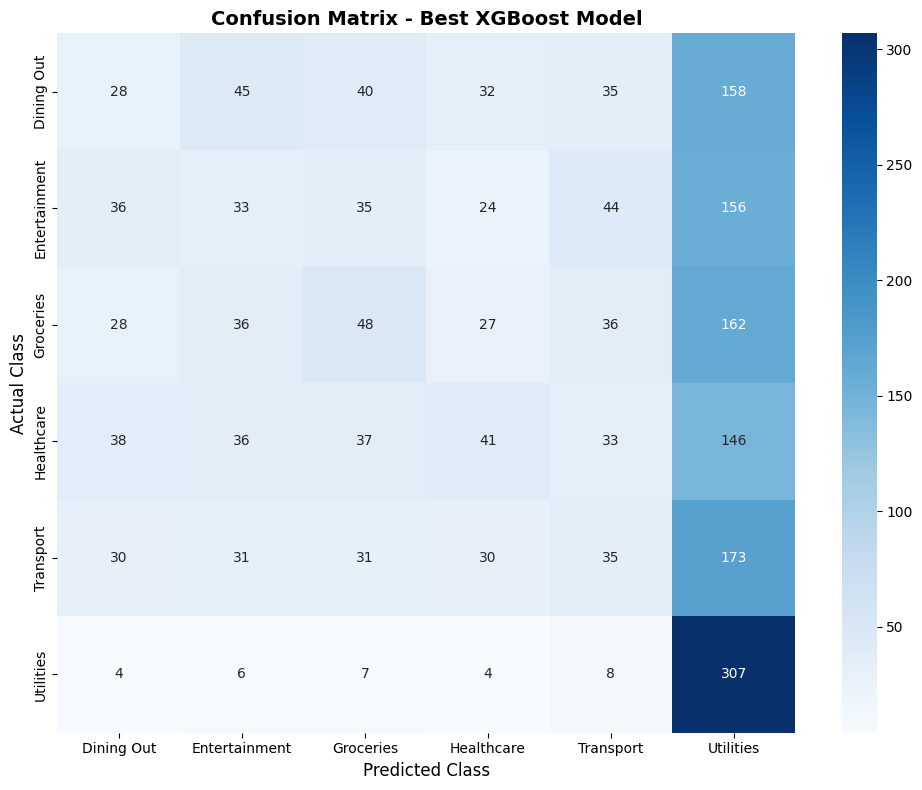


📊 Feature Importance:
                 feature  importance
4             cluster_id    0.889516
0                 amount    0.035893
3  amount_rolling_mean_3    0.025097
2            amount_lag2    0.025015
1            amount_lag1    0.024479


/var/folders/wc/d50td_fd3y79bpzgzcdvhgp80000gn/T/ipykernel_56478/1372321456.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_df, palette='viridis')


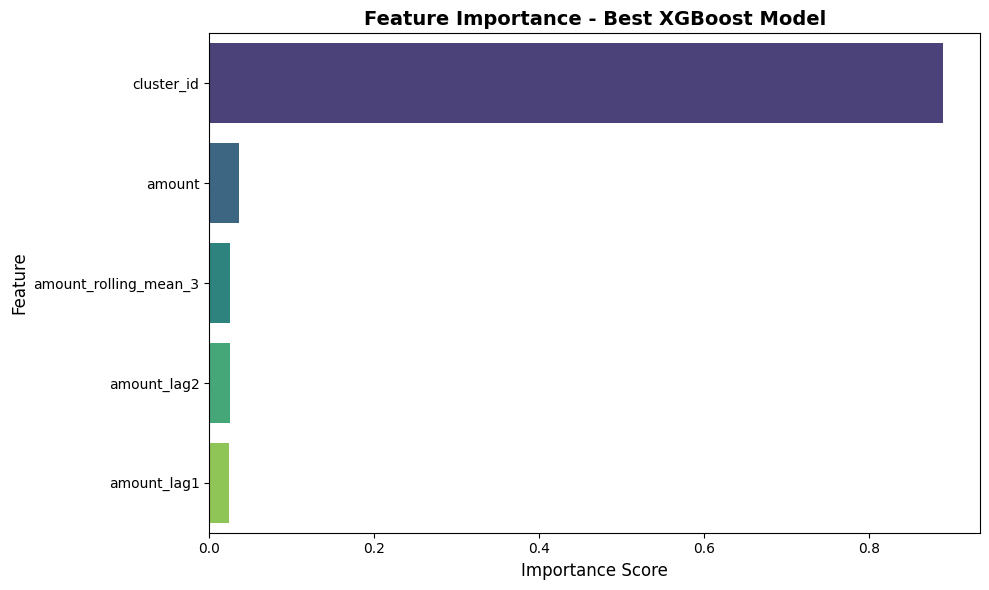

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions (numeric labels)
y_pred_numeric = best_xgb.predict(X_test)

# Decode predictions to original labels (if label_encoder exists)
if 'label_encoder' in globals() and label_encoder is not None:
    y_pred = label_encoder.inverse_transform(y_pred_numeric)
    y_test_eval = y_test_original  # Use original labels for evaluation
    print("✅ Predictions decoded to original class names")
else:
    y_pred = y_pred_numeric
    y_test_eval = y_test_numeric  # Use numeric labels if no encoder
    print("✅ Using numeric labels for evaluation")

print("\n📊 Classification Report:")
print(classification_report(y_test_eval, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test_eval, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_ if 'label_encoder' in globals() and label_encoder is not None else None,
            yticklabels=label_encoder.classes_ if 'label_encoder' in globals() and label_encoder is not None else None)
plt.title('Confusion Matrix - Best XGBoost Model', fontsize=14, fontweight='bold')
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.show()

# Feature Importance
importances = best_xgb.feature_importances_
feat_df = pd.DataFrame({'feature': X_test.columns, 'importance': importances}).sort_values('importance', ascending=False)
print("\n📊 Feature Importance:")
print(feat_df)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_df, palette='viridis')
plt.title('Feature Importance - Best XGBoost Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# STEP 6: COMPREHENSIVE GUIDE TO EVALUATION METRICS & FEATURE IMPORTANCE
# ============================================================================
# Deep dive into evaluation concepts, F1-score, and feature importance
# ============================================================================

print("="*70)
print("COMPREHENSIVE GUIDE: EVALUATION METRICS & FEATURE IMPORTANCE")
print("="*70)

# ============================================================================
# CONCEPT 1: EVALUATION METRICS - WHY MULTIPLE METRICS?
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 1: EVALUATION METRICS - WHY MULTIPLE METRICS?")
print("="*70)

print("""
📊 WHY NOT JUST USE ACCURACY?

Accuracy alone can be misleading, especially with imbalanced data!

Example: Medical Diagnosis (Cancer Detection)
  - 1000 patients: 990 healthy, 10 have cancer
  - Model predicts "healthy" for everyone
  - Accuracy = 990/1000 = 99% ✅
  - But: Found 0/10 cancers ❌
  - This is a TERRIBLE model for cancer detection!

→ We need metrics that tell us MORE than just overall correctness

KEY EVALUATION METRICS:

1. ACCURACY
   - What: Overall percentage of correct predictions
   - Formula: (Correct Predictions) / (Total Predictions)
   - When to use: Balanced datasets, when all classes matter equally
   - Limitation: Misleading with imbalanced data

2. PRECISION
   - What: Of predictions for a class, how many were correct?
   - Formula: True Positives / (True Positives + False Positives)
   - Question: "When I predict X, how often am I right?"
   - When to use: When false positives are costly
   - Example: Spam detection (don't want to mark real emails as spam)

3. RECALL (Sensitivity)
   - What: Of actual examples in a class, how many did we find?
   - Formula: True Positives / (True Positives + False Negatives)
   - Question: "Of all actual X, how many did I catch?"
   - When to use: When false negatives are costly
   - Example: Cancer detection (don't want to miss any cancers)

4. F1-SCORE
   - What: Harmonic mean of Precision and Recall
   - Formula: 2 × (Precision × Recall) / (Precision + Recall)
   - When to use: When you need balance between precision and recall
   - Best for: Imbalanced datasets, when both false positives and false negatives matter

5. SUPPORT
   - What: Number of actual examples in each class
   - Purpose: Shows how many examples each metric is based on
   - Helps: Understand if metrics are reliable (more support = more reliable)
""")

# ============================================================================
# CONCEPT 2: F1-SCORE - DEEP DIVE
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 2: F1-SCORE - DEEP DIVE")
print("="*70)

print("""
🎯 WHAT IS F1-SCORE?

F1-Score = Harmonic Mean of Precision and Recall

Why "Harmonic Mean" instead of regular average?
  - Regular average: (Precision + Recall) / 2
  - Harmonic mean: 2 × (Precision × Recall) / (Precision + Recall)
  - Harmonic mean penalizes extreme values more!

Example Comparison:

Scenario 1: Precision = 0.9, Recall = 0.1
  Regular Average: (0.9 + 0.1) / 2 = 0.5
  Harmonic Mean: 2 × (0.9 × 0.1) / (0.9 + 0.1) = 0.18
  → Harmonic mean shows the model is actually poor!

Scenario 2: Precision = 0.5, Recall = 0.5
  Regular Average: (0.5 + 0.5) / 2 = 0.5
  Harmonic Mean: 2 × (0.5 × 0.5) / (0.5 + 0.5) = 0.5
  → Both are equal when balanced

WHY F1-SCORE MATTERS:

1. BALANCES PRECISION AND RECALL
   - High Precision + Low Recall → Low F1
   - Low Precision + High Recall → Low F1
   - High Precision + High Recall → High F1
   - Forces you to optimize both!

2. HANDLES IMBALANCED DATA
   - Accuracy can be misleading with imbalanced classes
   - F1-score gives equal weight to each class (when using macro-average)
   - Better indicator of model quality

3. SINGLE METRIC TO OPTIMIZE
   - Instead of optimizing precision OR recall
   - Optimize F1-score to balance both
   - Simpler hyperparameter tuning

F1-SCORE RANGES:

┌──────────┬──────────────┬────────────────────────────┐
│ F1-Score │ Quality      │ Interpretation              │
├──────────┼──────────────┼────────────────────────────┤
│ 0.9-1.0  │ Excellent    │ Model is very good         │
│ 0.7-0.9  │ Good         │ Model is reliable          │
│ 0.5-0.7  │ Fair         │ Model needs improvement    │
│ 0.3-0.5  │ Poor         │ Model has issues           │
│ 0.0-0.3  │ Very Poor    │ Model is not working well  │
└──────────┴──────────────┴────────────────────────────┘

F1-SCORE VARIANTS:

1. F1-Micro (Micro-Averaged F1)
   - Calculates F1 globally across all classes
   - Treats each prediction equally
   - Good for: Overall model performance
   - Formula: Uses total TP, FP, FN across all classes

2. F1-Macro (Macro-Averaged F1)
   - Calculates F1 for each class, then averages
   - Treats each class equally (regardless of class size)
   - Good for: Imbalanced datasets
   - Formula: Average of F1-scores for each class

3. F1-Weighted (Weighted-Averaged F1)
   - Calculates F1 for each class, then weighted average
   - Weights by number of samples in each class
   - Good for: When class sizes matter
   - Formula: Weighted average of F1-scores

PRACTICAL EXAMPLE:

Email Classification: Spam vs Not Spam
  Class 1 (Spam): Precision=0.95, Recall=0.80
    F1 = 2 × (0.95 × 0.80) / (0.95 + 0.80) = 0.87
  
  Class 2 (Not Spam): Precision=0.85, Recall=0.98
    F1 = 2 × (0.85 × 0.98) / (0.85 + 0.98) = 0.91
  
  Macro F1 = (0.87 + 0.91) / 2 = 0.89
  → Good overall performance!

WHEN TO USE F1-SCORE:

✅ Use F1-Score when:
  - You have imbalanced classes
  - Both precision and recall matter
  - You need a single metric to optimize
  - False positives AND false negatives are costly

❌ Don't rely ONLY on F1-Score when:
  - Classes are very imbalanced (use per-class F1)
  - One metric is more important (use precision OR recall)
  - You need to understand specific failures (use confusion matrix)
""")

# ============================================================================
# CONCEPT 3: CONFUSION MATRIX - VISUALIZING ERRORS
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 3: CONFUSION MATRIX - VISUALIZING ERRORS")
print("="*70)

print("""
📋 WHAT IS A CONFUSION MATRIX?

A table showing how predictions compare to actual values

Structure:
                    Predicted
                  Class A  Class B  Class C
  Actual  Class A    TP      FP      FP
          Class B    FN      TP      FP
          Class C    FN      FN      TP

  TP = True Positive (correct prediction)
  FP = False Positive (predicted A, but was actually B/C)
  FN = False Negative (was A, but predicted B/C)

EXAMPLE: Expense Category Prediction

                    Predicted
              Dining  Groceries  Transport
  Actual  Dining      150        20        10
          Groceries    15       180        5
          Transport    10        5        185

Interpretation:
  - Dining: 150 correct, 20 confused with Groceries, 10 with Transport
  - Groceries: 180 correct, 15 confused with Dining, 5 with Transport
  - Transport: 185 correct, 10 confused with Dining, 5 with Groceries

WHAT IT TELLS US:

1. DIAGONAL VALUES (Correct Predictions)
   - Higher = better
   - Shows which classes are predicted well

2. OFF-DIAGONAL VALUES (Misclassifications)
   - Shows which classes are confused with each other
   - Helps identify similar/problematic classes

3. PATTERNS
   - If one class has many misclassifications → Hard to predict
   - If two classes are often confused → They might be similar
   - If all off-diagonal values are low → Model is good

HOW TO READ A CONFUSION MATRIX:

Step 1: Look at diagonal (correct predictions)
  - Are they high? → Good!
  - Are they low? → Model struggles with that class

Step 2: Look at rows (actual classes)
  - Where do errors go? → Which classes are confused?
  - Are errors spread out? → Model is uncertain

Step 3: Look at columns (predicted classes)
  - Which predictions are often wrong? → Overconfident class?
  - Are predictions balanced? → Model bias?

PRACTICAL USE:

1. IDENTIFY PROBLEM CLASSES
   - Low diagonal value = hard to predict class
   - Many off-diagonal values = confused class

2. FEATURE ENGINEERING
   - If A and B are confused → Add features to distinguish them
   - If one class always wrong → Check if features are missing

3. MODEL IMPROVEMENT
   - Focus on classes with low precision/recall
   - Collect more data for confused classes
   - Adjust class weights for imbalanced classes
""")

# ============================================================================
# CONCEPT 4: PRECISION, RECALL, AND THEIR TRADE-OFF
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 4: PRECISION, RECALL, AND THEIR TRADE-OFF")
print("="*70)

print("""
⚖️ THE PRECISION-RECALL TRADE-OFF

Precision and Recall often work against each other!

Example: Spam Detection

High Precision (Low Recall):
  - Only predict "spam" when 100% sure
  - Result: Few false positives (good!)
  - But: Miss many actual spam emails (bad!)
  - Precision: 0.95, Recall: 0.30

High Recall (Low Precision):
  - Predict "spam" when even slightly suspicious
  - Result: Catch most spam emails (good!)
  - But: Mark many real emails as spam (bad!)
  - Precision: 0.60, Recall: 0.95

Balanced (Good F1-Score):
  - Find middle ground
  - Result: Reasonable precision and recall
  - Precision: 0.85, Recall: 0.80, F1: 0.82

WHEN TO PRIORITIZE PRECISION:

✅ High Precision Important:
  - Email spam detection (don't block important emails)
  - Medical diagnosis (don't give false positives)
  - Fraud detection (don't block legitimate transactions)
  - Recommendation systems (only show relevant items)

Example: "Only recommend products I'm 95% sure they'll like"

WHEN TO PRIORITIZE RECALL:

✅ High Recall Important:
  - Cancer detection (don't miss any cancers)
  - Security systems (don't miss threats)
  - Search engines (don't miss relevant results)
  - Quality control (don't miss defective products)

Example: "Catch 99% of defective products, even if some false alarms"

WHEN TO BALANCE (F1-SCORE):

✅ Balance Important:
  - General classification tasks
  - When both errors are costly
  - When you need reliable predictions
  - When optimizing for overall performance

Example: "Balance between catching spam and not blocking real emails"

PRECISION-RECALL CURVE:

Visual representation of the trade-off:

Recall (x-axis) vs Precision (y-axis)

  Precision
    1.0 |●
        |  ●
    0.8 |    ●
        |      ●
    0.6 |        ●
        |          ●
    0.4 |            ●
        |              ●
    0.2 |                ●
        |                  ●
    0.0 |____________________●
        0.0  0.2  0.4  0.6  0.8  1.0  Recall

  - Higher curve = Better model
  - Area under curve (AUC-PR) = Overall performance metric
  - Good for: Imbalanced datasets
""")

# ============================================================================
# CONCEPT 5: FEATURE IMPORTANCE - WHAT MATTERS MOST?
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 5: FEATURE IMPORTANCE - WHAT MATTERS MOST?")
print("="*70)

print("""
🔍 WHAT IS FEATURE IMPORTANCE?

Feature Importance = How much each feature contributes to predictions

Think of it as: "Which features does the model rely on most?"

EXAMPLE: Predicting House Price

Features:
  - Size (sq ft)
  - Location (zip code)
  - Age (years)
  - Bedrooms
  - Bathrooms

Feature Importance:
  - Location: 0.45 (45% importance)
  - Size: 0.30 (30% importance)
  - Age: 0.15 (15% importance)
  - Bedrooms: 0.07 (7% importance)
  - Bathrooms: 0.03 (3% importance)

Interpretation:
  - Location matters most (45%)
  - Size is second most important (30%)
  - Bedrooms and bathrooms matter less (7% + 3%)

HOW FEATURE IMPORTANCE IS CALCULATED:

1. TREE-BASED MODELS (Random Forest, XGBoost)
   - Count how often feature is used for splits
   - Weight by how much it improves predictions
   - Average across all trees
   - Higher usage = Higher importance

2. LINEAR MODELS (Logistic Regression, Linear Regression)
   - Use coefficient magnitudes
   - Larger absolute coefficient = More important
   - Normalize by feature scale

3. PERMUTATION IMPORTANCE
   - Shuffle one feature at a time
   - See how much accuracy drops
   - Larger drop = More important feature

WHAT FEATURE IMPORTANCE TELLS US:

1. WHICH FEATURES MATTER
   - High importance = Feature is useful
   - Low importance = Feature might be redundant
   - Zero importance = Feature is not used

2. FEATURE SELECTION
   - Remove low-importance features
   - Keep only important features
   - Reduces model complexity
   - May improve performance

3. DOMAIN INSIGHTS
   - Understand what drives predictions
   - Validate business assumptions
   - Discover unexpected patterns

4. MODEL INTERPRETABILITY
   - Explain why model makes predictions
   - Build trust with stakeholders
   - Debug model behavior

FEATURE IMPORTANCE INTERPRETATION:

┌──────────────┬──────────────┬────────────────────────────┐
│ Importance   │ Value Range  │ Interpretation              │
├──────────────┼──────────────┼────────────────────────────┤
│ Very High     │ 0.3 - 1.0    │ Critical feature           │
│ High         │ 0.1 - 0.3    │ Important feature          │
│ Medium       │ 0.05 - 0.1   │ Useful feature             │
│ Low          │ 0.01 - 0.05  │ Minor feature              │
│ Very Low     │ 0.0 - 0.01   │ Negligible/Redundant       │
└──────────────┴──────────────┴────────────────────────────┘

CAUTIONS WITH FEATURE IMPORTANCE:

1. CORRELATED FEATURES
   - If two features are highly correlated
   - Importance might be split between them
   - One might show low importance even if it's useful
   - Solution: Check feature correlations

2. SCALE DEPENDENCE
   - Some methods are sensitive to feature scale
   - Normalize features before calculating importance
   - Use permutation importance for scale-independent measure

3. NOT CAUSAL
   - High importance ≠ Feature causes the outcome
   - Might be correlation, not causation
   - Example: "Ice cream sales" and "Swimming pool accidents"
   - Both correlate with "Summer" (actual cause)

4. MODEL-SPECIFIC
   - Different models may show different importances
   - Random Forest vs XGBoost might differ
   - Use multiple models to validate

PRACTICAL APPLICATIONS:

1. FEATURE ENGINEERING
   - Focus on high-importance features
   - Create new features from important ones
   - Remove or combine low-importance features

2. DATA COLLECTION
   - Prioritize collecting high-importance features
   - May not need to collect low-importance features
   - Saves time and resources

3. MODEL SIMPLIFICATION
   - Remove features with < 1% importance
   - Reduces overfitting risk
   - Faster training and prediction

4. BUSINESS INSIGHTS
   - Understand what drives business outcomes
   - Validate hypotheses
   - Guide strategic decisions

EXAMPLE: Expense Category Prediction

Feature Importance Results:
  - cluster_id: 0.89 (89%) → Very important!
  - amount: 0.04 (4%) → Minor importance
  - amount_lag1: 0.03 (3%) → Minor importance
  - amount_lag2: 0.02 (2%) → Minor importance
  - amount_rolling_mean_3: 0.02 (2%) → Minor importance

Interpretation:
  - User cluster is the most important predictor
  - Spending amount and history matter less
  - Suggests: User behavior patterns (clusters) drive categories
  - Action: Focus on improving cluster features
""")

# ============================================================================
# CONCEPT 6: PUTTING IT ALL TOGETHER
# ============================================================================
print("\n" + "="*70)
print("CONCEPT 6: PUTTING IT ALL TOGETHER")
print("="*70)

print("""
🔗 HOW EVALUATION METRICS AND FEATURE IMPORTANCE WORK TOGETHER:

1. EVALUATE MODEL PERFORMANCE
   - Use Accuracy for overall performance
   - Use Precision/Recall/F1 for detailed analysis
   - Use Confusion Matrix to identify problem areas

2. ANALYZE FEATURE IMPORTANCE
   - Identify which features matter most
   - Find redundant or useless features
   - Understand model behavior

3. IMPROVE MODEL
   - Focus on classes with low F1-scores
   - Improve or add features with high importance
   - Remove features with zero importance
   - Collect more data for confused classes

4. ITERATE
   - Re-evaluate after changes
   - Compare metrics before/after
   - Continue improving

EVALUATION WORKFLOW:

Step 1: Train Model
  ↓
Step 2: Evaluate with Multiple Metrics
  - Accuracy (overall)
  - Precision/Recall/F1 (per-class)
  - Confusion Matrix (errors)
  ↓
Step 3: Analyze Feature Importance
  - Which features matter?
  - Which can be removed?
  ↓
Step 4: Identify Problems
  - Low F1-score classes
  - Confused class pairs
  - Useless features
  ↓
Step 5: Make Improvements
  - Feature engineering
  - Data collection
  - Hyperparameter tuning
  ↓
Step 6: Re-evaluate
  - Compare new metrics
  - Check if problems fixed
  ↓
Step 7: Repeat until satisfied

BEST PRACTICES:

✅ DO:
  - Use multiple metrics (not just accuracy)
  - Check F1-score for each class
  - Analyze confusion matrix for patterns
  - Review feature importance regularly
  - Consider business context when choosing metrics

❌ DON'T:
  - Rely only on accuracy
  - Ignore low-importance features without checking
  - Overlook confusion matrix patterns
  - Optimize one metric at expense of others
  - Forget to validate on test set
""")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("SUMMARY: KEY CONCEPTS")
print("="*70)

print("""
✅ EVALUATION METRICS:
   - Accuracy: Overall correctness
   - Precision: Of predictions, how many correct?
   - Recall: Of actual examples, how many found?
   - F1-Score: Harmonic mean of Precision and Recall
   - Support: Number of examples per class

✅ F1-SCORE:
   - Balances Precision and Recall
   - Better for imbalanced data than Accuracy
   - Harmonic mean penalizes extreme values
   - Variants: Micro, Macro, Weighted

✅ CONFUSION MATRIX:
   - Visualizes prediction errors
   - Shows which classes are confused
   - Helps identify problem areas
   - Guides model improvement

✅ FEATURE IMPORTANCE:
   - Shows which features matter most
   - Helps with feature selection
   - Provides model interpretability
   - Guides feature engineering

✅ BEST PRACTICES:
   - Use multiple metrics
   - Analyze per-class performance
   - Review confusion matrix
   - Check feature importance
   - Iterate and improve

NEXT STEPS:
- Practice interpreting evaluation metrics
- Experiment with different models
- Analyze feature importance in your projects
- Use metrics to guide model improvement
""")

print("\n" + "="*70)
print("EVALUATION & FEATURE IMPORTANCE GUIDE COMPLETE!")
print("="*70)


In [16]:
# Compare to Week 1 model (assume old_rf from prior)
old_f1 = f1_score(y_test, old_rf.predict(X_test), average='macro')
new_f1 = f1_score(y_test, y_pred, average='macro')
comparison = pd.DataFrame({'Model': ['Old RF', 'Tuned XGB'], 'F1': [old_f1, new_f1]})
print(comparison)

import joblib
joblib.dump(best_xgb, 'src/enhanced_classifier.pkl')

NameError: name 'f1_score' is not defined